#Importação das bibliotecas

In [4]:
pip install Prophet

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from prophet import Prophet
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

#Buscando e tratando os dados da tabela do IBOVESPA

Transformamos a data no Dtype date e as outras variáveis em int, para manter a escala correta, exceto com Volume, mantido como float

In [6]:
df = pd.read_csv('/content/Dados Históricos - Ibovespa 2005-2025.csv')

# Seleciona apenas as colunas 'Data' e 'Último'
df_filtered = df[['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.']].copy()

# Converte a coluna 'Data' para datetime no formato dd.MM.yyyy
df_filtered['Data'] = pd.to_datetime(df_filtered['Data'], format='%d.%m.%Y')

# Remove o ponto e adiciona '.0' no final, depois converte para int
df_filtered['Close'] = (df_filtered['Último'] * 1000).astype(int)
df_filtered['Abertura'] = (df_filtered['Abertura'] * 1000).astype(int)
df_filtered['Max'] = (df_filtered['Máxima'] * 1000).astype(int)
df_filtered['Min'] = (df_filtered['Mínima'] * 1000).astype(int)

# Trata coluna Vol.

df_filtered['Vol'] = df['Vol.'].str.replace(',', '.', regex=False).str.replace('B', '', regex=False).str.replace('M', '', regex=False).str.replace('K', '', regex=False).astype(float)

# Remove a coluna antiga 'Último'
df_filtered.drop(columns=['Último', 'Vol.', 'Máxima', 'Mínima'], inplace=True)

# Exibe as primeiras linhas para conferência
print(df_filtered.head())

        Data  Abertura   Close     Max     Min    Vol
0 2025-03-11    124519  123507  124625  122636   8.81
1 2025-03-10    125031  124519  125031  123471   9.37
2 2025-03-07    123357  125035  125822  122530   9.98
3 2025-03-06    123048  123358  124112  122681  10.06
4 2025-03-05    122799  123047  123364  122747   9.60


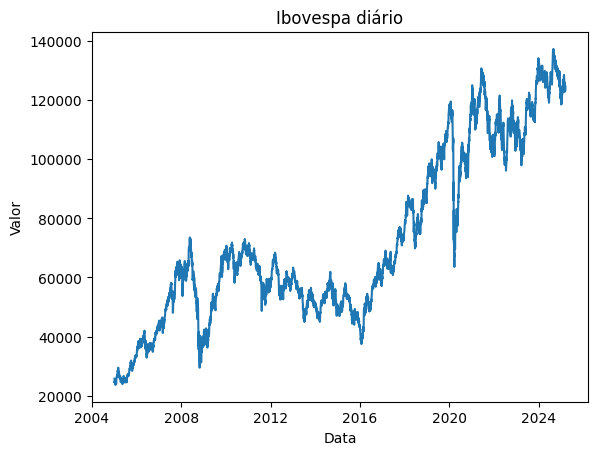

In [7]:
# Visualização inicial dos dados

plt.plot(df_filtered['Data'], df_filtered["Close"])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Ibovespa diário')
plt.show()

#Diminuindo o intervalo

Há uma diferença muito clara nos dados a partir de 2016, então optamos por inicialmente pegar os dados a partir desse momento

In [8]:
# Filtra os dados a partir de 2016
df_filtered = df_filtered[df_filtered['Data'].dt.year >= 2016]

#Adicionando mais dados de interesse

Por se tratar de uma análise de índice de bolsa optamos por adicionar o fechamento da cotação do Dólar americano. Existe uma inter relação conhecida entre os dois, então faz sentido levar em consideração

In [9]:
df2 = pd.read_csv('/content/USD_BRL Dados Históricos.csv')

# Seleciona apenas as colunas 'Data' e 'Último'
df2_filtered = df2[['Data', 'Último']].copy()

# Converte a coluna 'Data' para datetime no formato dd.MM.yyyy
df2_filtered['Data'] = pd.to_datetime(df2_filtered['Data'], format='%d.%m.%Y')

# Substitui a vírgula por ponto e converte para float
df2_filtered['usd_close'] = df2_filtered['Último'].str.replace(',', '.', regex=False).astype(float)

# Remove a coluna antiga 'Último'
df2_filtered.drop(columns='Último', inplace=True)

# Exibe as primeiras linhas para conferência
print(df2_filtered.head())

        Data  usd_close
0 2025-08-15     5.3976
1 2025-08-14     5.4160
2 2025-08-13     5.3991
3 2025-08-12     5.3895
4 2025-08-11     5.4424


In [10]:
# Junta os dois DataFrames pela coluna 'Data', mantendo apenas datas que existem em ambos
df_merged = pd.merge(df_filtered, df2_filtered, on='Data', how='inner')

# Exibe as primeiras linhas para conferência
print(df_merged.head(10))

        Data  Abertura   Close     Max     Min    Vol  usd_close
0 2025-03-11    124519  123507  124625  122636   8.81     5.8103
1 2025-03-10    125031  124519  125031  123471   9.37     5.8555
2 2025-03-07    123357  125035  125822  122530   9.98     5.7874
3 2025-03-06    123048  123358  124112  122681  10.06     5.7639
4 2025-03-05    122799  123047  123364  122747   9.60     5.7394
5 2025-02-28    124798  122799  124916  122659  24.87     5.8852
6 2025-02-27    124768  124799  125497  124352  12.55     5.8401
7 2025-02-26    125980  124769  126563  124732  11.36     5.8035
8 2025-02-25    125401  125980  126718  125382  11.08     5.7396
9 2025-02-24    127129  125401  127275  125162  10.15     5.7785


#Engenharia de atributos

Para melhorar a capacidade dos algoritmos de interpretar os dados incluímos outras variáveis criadas a partir das que já temos:
- log_return: Captura variações percentuais de forma mais estável e simétrica, útil para modelagem estatística e para evitar distorções em grandes variações.
- ma_5 e ma_20: Indicadores de tendência.
- lag_1 e lag_5: Capturam dependência temporal direta.
- volat_5: Mede o risco recente.
- usd_pct_change: Pode capturar efeitos macroeconômicos ou externos que influenciam o ativo analisado.
- Vol_5: Pode indicar interesse ou pressão de compra/venda.

Adicionalmente, incluímos posteriormente outras variáveis através de pesquisas mais aprofundadas com o objetivo de refinar os modelos:
- RSI: Identifica condições de sobrecompra (>70) ou sobrevenda (<30).
- MACD:  Indicador de momentum. Cruzamentos entre MACD e sua linha de sinal são usados para prever reversões ou confirmações de tendência.
- Bollinger Bands:  Medem a volatilidade e ajudam a identificar extremos de preço. Preços fora das bandas podem sinalizar reversões ou continuação.

In [11]:
df_tratado = df_merged.copy()
df_tratado["log_return"] = np.log(df_tratado["Close"] / df_tratado["Close"].shift(1))
df_tratado["ma_5"] = df_tratado["Close"].rolling(window=5).mean()
df_tratado["ma_20"] = df_tratado["Close"].rolling(window=20).mean()
df_tratado["lag_1"] = df_tratado["Close"].shift(1)
df_tratado["lag_5"] = df_tratado["Close"].shift(5)
df_tratado["volat_5"] = df_tratado["log_return"].rolling(window=5).std()
df_tratado["usd_pct_change"] = df_tratado["usd_close"].pct_change()
df_tratado['Vol_5'] = df_tratado['Vol'].rolling(window=5).std()
df_tratado.tail()

,Data,Abertura,Close,Max,Min,Vol,usd_close,log_return,ma_5,ma_20,lag_1,lag_5,volat_5,usd_pct_change,Vol_5
2275,2016-01-08,40695,40612,41218,40463,3.32,4.0230,0.016435,39704.0,39077.70,39950.0,38569.0,0.014480,-0.007206,0.317128
2276,2016-01-07,41772,40695,41772,40695,4.16,4.0433,0.002042,39943.0,39082.85,40612.0,39500.0,0.012541,0.005046,0.381156
2277,2016-01-06,42410,41773,42410,41590,4.06,4.0229,0.026145,40508.8,39130.40,40695.0,38944.0,0.008745,-0.005045,0.442516
2278,2016-01-05,42139,42419,42534,42137,2.64,4.0062,0.015346,41089.8,39271.90,41773.0,39514.0,0.008764,-0.004151,0.636333
2279,2016-01-04,43349,42141,43349,42125,3.07,4.0387,-0.006575,41528.0,39449.15,42419.0,39950.0,0.012908,0.008112,0.650692


In [12]:
# Cria RSI

window = 14
delta = df_tratado['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()
rs = avg_gain / avg_loss
df_tratado['RSI'] = 100 - (100 / (1 + rs))

# Cria MACD

ema_12 = df_tratado['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df_tratado['Close'].ewm(span=26, adjust=False).mean()
df_tratado['MACD'] = ema_12 - ema_26
df_tratado['MACD_signal'] = df_tratado['MACD'].ewm(span=9, adjust=False).mean()

# Cria Bollinger Bands

ma_20 = df_tratado['Close'].rolling(window=20).mean()
std_20 = df_tratado['Close'].rolling(window=20).std()
df_tratado['Bollinger_upper'] = ma_20 + (2 * std_20)
df_tratado['Bollinger_lower'] = ma_20 - (2 * std_20)

df_tratado.tail()

,Data,Abertura,Close,Max,Min,Vol,usd_close,log_return,ma_5,ma_20,lag_1,lag_5,volat_5,usd_pct_change,Vol_5,RSI,MACD,MACD_signal,Bollinger_upper,Bollinger_lower
2275,2016-01-08,40695,40612,41218,40463,3.32,4.0230,0.016435,39704.0,39077.70,39950.0,38569.0,0.014480,-0.007206,0.317128,51.264114,-779.164193,-1302.974134,41330.884423,36824.515577
2276,2016-01-07,41772,40695,41772,40695,4.16,4.0433,0.002042,39943.0,39082.85,40612.0,39500.0,0.012541,0.005046,0.381156,65.995352,-610.009449,-1164.381197,41351.028706,36814.671294
2277,2016-01-06,42410,41773,42410,41590,4.06,4.0229,0.026145,40508.8,39130.40,40695.0,38944.0,0.008745,-0.005045,0.442516,73.334249,-384.534826,-1008.411923,41584.357440,36676.442560
2278,2016-01-05,42139,42419,42534,42137,2.64,4.0062,0.015346,41089.8,39271.90,41773.0,39514.0,0.008764,-0.004151,0.636333,84.927619,-151.965993,-837.122737,42130.246589,36413.553411
2279,2016-01-04,43349,42141,43349,42125,3.07,4.0387,-0.006575,41528.0,39449.15,42419.0,39950.0,0.012908,0.008112,0.650692,80.265096,9.801224,-667.737945,42559.564850,36338.735150


#Criando uma variável binária

Alguns algoritmos lidam melhor com variáveis binárias, então criamos uma com valor 1 se o fechamento foi positivo no dia

In [13]:
df_tratado['target'] = (df_tratado['Close'].shift(-1) > df_tratado['Close']).astype(int)
df_tratado.head(30)

,Data,Abertura,Close,Max,Min,Vol,usd_close,log_return,ma_5,ma_20,...,lag_5,volat_5,usd_pct_change,Vol_5,RSI,MACD,MACD_signal,Bollinger_upper,Bollinger_lower,target
0,2025-03-11,124519,123507,124625,122636,8.81,5.8103,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1
1,2025-03-10,125031,124519,125031,123471,9.37,5.8555,0.008160,NaN,NaN,...,NaN,NaN,0.007779,NaN,NaN,80.729345,16.145869,NaN,NaN,1
2,2025-03-07,123357,125035,125822,122530,9.98,5.7874,0.004135,NaN,NaN,...,NaN,NaN,-0.011630,NaN,NaN,184.221232,49.760942,NaN,NaN,0
3,2025-03-06,123048,123358,124112,122681,10.06,5.7639,-0.013503,NaN,NaN,...,NaN,NaN,-0.004061,NaN,NaN,129.427454,65.694244,NaN,NaN,0
4,2025-03-05,122799,123047,123364,122747,9.60,5.7394,-0.002524,123893.2,NaN,...,NaN,NaN,-0.004251,0.506587,NaN,60.213783,64.598152,NaN,NaN,0
5,2025-02-28,124798,122799,124916,122659,24.87,5.8852,-0.002018,123751.6,NaN,...,123507.0,0.008214,0.025403,6.766589,NaN,-14.483125,48.781896,NaN,NaN,1
6,2025-02-27,124768,124799,125497,124352,12.55,5.8401,0.016156,123807.6,NaN,...,124519.0,0.010838,-0.007663,6.511042,NaN,86.702866,56.366090,NaN,NaN,0
7,2025-02-26,125980,124769,126563,124732,11.36,5.8035,-0.000240,123754.4,NaN,...,125035.0,0.010641,-0.006267,6.356608,NaN,162.598410,77.612554,NaN,NaN,1
8,2025-02-25,125401,125980,126718,125382,11.08,5.7396,0.009659,124278.8,NaN,...,123358.0,0.008312,-0.011011,6.226096,NaN,316.811746,125.452393,NaN,NaN,0
9,2025-02-24,127129,125401,127275,125162,10.15,5.7785,-0.004607,124749.6,NaN,...,123047.0,0.008773,0.006777,6.135509,NaN,387.835736,177.929061,NaN,NaN,1


#Seleção de algoritmos

Usaremos como base de comparação o algorítmo mais simples, ARIMA. Ele não precisa de outras variáveis, mas precisa de um target estacionário e com valores contínuos

In [14]:
# Testando estacionariedade de log_retur

result = adfuller(df_tratado['log_return'].dropna())
print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")
for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -12.210860239445864
P-Value: 1.1646878364325153e-22
Valores críticos:
	1%: -3.43323655938138
	5%: -2.86281520927122
	10%: -2.567448852970086


In [15]:
df_arima = df_tratado[['Data', 'log_return']].dropna().copy()
df_arima = df_arima.set_index("Data").asfreq("B").ffill()
df_arima.head()

,log_return
Data,
2016-01-04,-0.006575
2016-01-05,0.015346
2016-01-06,0.026145
2016-01-07,0.002042
2016-01-08,0.016435


log_return pode ser usada como targer par ARIMA por ser estacionária (p<0,05), então usamos forward fill para completar os valores

#Treino e teste com ARIMA

Para todos os modelos vamos usar walk-forward no processo de treino e teste para simular adequadamente o funcionamento da série, melhorando sua robustez e evitando o lookahead bias

In [16]:
# Separar os últimos 30 dias para teste
df_train = df_arima.iloc[:-30].copy()
df_test = df_arima.iloc[-30:].copy()

# Inicializar lista para armazenar previsões
predictions = []

# Copiar série de treino para iniciar o walk-forward
series_walk = df_train['log_return'].copy()

# Loop de walk-forward
for i in range(len(df_test)):
    # Treinar modelo ARIMA
    model = ARIMA(series_walk, order=(1, 0, 0))  # Ajuste (p,d,q) conforme necessário
    model_fit = model.fit()

    # Fazer previsão para o próximo ponto
    forecast = model_fit.forecast(steps=1).item()  # Use .item() to get the scalar value
    predictions.append(forecast)

    # Atualizar série com o valor real do teste
    series_walk = pd.concat([series_walk, pd.Series(df_test['log_return'].iloc[i].item(), index=[df_test.index[i]])]) # Use .item() and set index

# Converter previsões em série
pred_series = pd.Series(predictions, index=df_test.index)

# Criar variáveis binárias para direção real e prevista
true_direction = (df_test['log_return'] > 0).astype(int)
pred_direction = (pred_series > 0).astype(int)

# Calcular métricas de classificação
accuracy_arima = accuracy_score(true_direction, pred_direction)
precision_arima = precision_score(true_direction, pred_direction)
recall_arima = recall_score(true_direction, pred_direction)
f1_arima = f1_score(true_direction, pred_direction)

# Exibir resultados
print(f"📊 Avaliação do modelo ARIMA com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_arima:.2%}")
print(f"Precisão : {precision_arima:.2%}")
print(f"Recall   : {recall_arima:.2%}")
print(f"F1-Score : {f1_arima:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_series = pd.concat([df_train['log_return'], df_test['log_return']])

# Treinar modelo ARIMA com todos os dados
model = ARIMA(full_series, order=(1, 0, 0))
model_fit = model.fit()

# Fazer previsão para o próximo dia
next_day_prediction = model_fit.forecast(steps=1).item()

# Determinar se é Alta ou Baixa (retorno positivo = alta, negativo = baixa)
if next_day_prediction > 0:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO ARIMA PARA O PRÓXIMO DIA:")
print(f"Retorno logarítmico previsto: {next_day_prediction:.4f}")
print(f"Direção prevista: {previsao_direcao}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dat

📊 Avaliação do modelo ARIMA com walk-forward (classificação de direção):
Acurácia : 56.67%
Precisão : 66.67%
Recall   : 14.29%
F1-Score : 23.53%

🎯 PREVISÃO ARIMA PARA O PRÓXIMO DIA:
Retorno logarítmico previsto: -0.0008
Direção prevista: BAIXA 📉


# Algoritmos mais complexos

O resultado do ARIMA, conforme esperado, não é muito bom para um modelo tão complexo. Por isso vamos testar modelos mais poderosos.

Prophet - Muito bom para lidar com a sazonalidade característica de índice da bolsa e aceita variáveis exógenas. Vamos tentar prever o valor de Close e então ver se é maior ou menor que o dia anterior

XGBoot e Random Forest - Target binária, conforme o objetivo do projeto.



#Preparação do dataframe para Prophet

Antes de treinar e testar o modelo precisamos selecionar as variáveis. Para o Prophet as variáveis mais importantes são as com maior correlação com Close. Caso haja correlação muito forte entre as outras variáveis, o que é esperado, então será necessário selecionar quais usar

In [17]:
# Copiar o DataFrame original
df_prophet = df_tratado.copy()

correlation_prophet = df_prophet.corr()["Close"].drop("Close").sort_values(ascending=False)
print(correlation_prophet)

Min                0.999481
Max                0.999305
Abertura           0.998434
lag_1              0.998425
ma_5               0.998297
lag_5              0.992921
ma_20              0.990075
Bollinger_upper    0.988387
Bollinger_lower    0.978103
Data               0.909012
usd_close          0.771137
MACD_signal        0.299683
MACD               0.282192
RSI                0.224812
log_return         0.054998
Vol                0.028665
target             0.013795
usd_pct_change    -0.032624
Vol_5             -0.100386
volat_5           -0.211258
Name: Close, dtype: float64


Baseado na correlaçao entre as variáveis com Close podemos inicialmente retirar do modelo algumas delas.

In [18]:
# Removendo variáveis pouco úteis
df_prophet = df_prophet.drop(columns=['volat_5', 'Vol_5', 'usd_pct_change', 'target', 'Vol', 'log_return'])

# Verificando correlação entre as variáveis restantes:
corr_prophet = df_prophet.drop(columns=['Data', 'Close']).corr()
print("📊 Correlação das variáveis entre si para ARIMAX:")
print(corr_prophet)

📊 Correlação das variáveis entre si para ARIMAX:
                 Abertura       Max       Min  usd_close      ma_5     ma_20  \
Abertura         1.000000  0.999370  0.999037   0.771838  0.996893  0.988389   
Max              0.999370  1.000000  0.999103   0.776064  0.997633  0.989203   
Min              0.999037  0.999103  1.000000   0.767522  0.997957  0.989814   
usd_close        0.771838  0.776064  0.767522   1.000000  0.773045  0.780770   
ma_5             0.996893  0.997633  0.997957   0.773045  1.000000  0.993937   
ma_20            0.988389  0.989203  0.989814   0.780770  0.993937  1.000000   
lag_1            0.997165  0.997914  0.998072   0.771826  0.999113  0.991590   
lag_5            0.991455  0.992116  0.992730   0.774283  0.996863  0.996022   
RSI              0.225278  0.225410  0.224155   0.077510  0.198703  0.111244   
MACD             0.283128  0.281828  0.282482  -0.011475  0.268736  0.176600   
MACD_signal      0.299996  0.298240  0.300670  -0.012488  0.294922  0.2

Baseado nessas correlações vamos remover as seguintes variáveis:
- Abertura, Max, Min: altíssima correlação entre si e com Close — redundantes.
- Bollinger_upper e Bollinger_lower: muito correlacionadas com ma_20 e entre si — redundantes.
- lag_5: muito similar a lag_1, menos informativo.
- MACD: Por MACD_signal ser suavizado
- ma_5: Redundante com ma_20

In [19]:
# Removendo outras colunas:
df_prophet = df_prophet.drop(columns=['Abertura', 'Max', 'Min', 'Bollinger_upper', 'Bollinger_lower', 'lag_5', 'MACD', 'ma_5'])

# Renomear colunas para Prophet
df_prophet = df_prophet.rename(columns={'Data': 'ds', 'Close': 'y'})

# Selecionar variáveis exógenas (regressores)
regressors = [
    'usd_close', 'ma_20', 'lag_1',
    'RSI', 'MACD_signal'
]

# Preencher valores nulos nas variáveis exógenas com forward fill e backward fill
df_prophet[regressors] = df_prophet[regressors].ffill()
df_prophet = df_prophet.iloc[19:]

# Remover linhas com valores nulos restantes (ex: início da série)
df_prophet = df_prophet.dropna(subset=['y'] + regressors)

# Separar os últimos 30 dias para teste
df_train_prophet = df_prophet.iloc[:-30].copy()
df_test_prophet = df_prophet.iloc[-30:].copy()

# Visualizar os primeiros dados de treino
print(df_train_prophet.head(20))

           ds       y  usd_close      ma_20     lag_1        RSI  MACD_signal
19 2025-02-10  125572     5.7874  125593.90  126522.0  59.357495   765.184491
20 2025-02-07  124619     5.8058  125649.50  125572.0  49.346405   705.112109
21 2025-02-06  126225     5.7617  125734.80  124619.0  54.743907   656.212342
22 2025-02-05  125534     5.7973  125759.75  126225.0  48.495886   604.358619
23 2025-02-04  125147     5.7540  125849.20  125534.0  49.132158   545.819857
24 2025-02-03  125970     5.8066  125995.35  125147.0  45.782957   498.046191
25 2025-01-31  126135     5.8410  126162.15  125970.0  44.538817   461.021584
26 2025-01-30  126913     5.8740  126267.85  126135.0  48.576359   444.036944
27 2025-01-29  123432     5.8563  126201.00  126913.0  34.226154   383.953957
28 2025-01-28  124056     5.8571  126104.80  123432.0  36.598891   309.087859
29 2025-01-27  124862     5.8926  126077.85  124056.0  40.266744   241.035383
30 2025-01-24  122447     5.9109  125843.80  124862.0  42.624762

# Treino e teste com Prophet

In [20]:
# Inicializar listas para armazenar previsões e verdadeiros
predictions = []
true_values = []

# Loop de walk-forward
for i in range(len(df_test_prophet)):
    # Criar e treinar o modelo Prophet
    model = Prophet()
    for reg in regressors:
        model.add_regressor(reg)

    # Treinar com dados até o dia i
    train_subset = pd.concat([df_train_prophet, df_test_prophet.iloc[:i]], axis=0)
    model.fit(train_subset[['ds', 'y'] + regressors])

    # Prever o próximo dia
    next_day = df_test_prophet.iloc[[i]].copy()
    forecast = model.predict(next_day[['ds'] + regressors])
    y_pred = forecast['yhat'].values[0]
    predictions.append(y_pred)
    true_values.append(next_day['y'].values[0])

# Criar variáveis binárias para direção real e prevista
true_direction = pd.Series(true_values) > pd.Series(true_values).shift(1)
pred_direction = pd.Series(predictions) > pd.Series(true_values).shift(1)

# Remover o primeiro valor (NaN por causa do shift)
true_direction = true_direction[1:].astype(int)
pred_direction = pred_direction[1:].astype(int)

# Calcular métricas de classificação
accuracy_prophet = accuracy_score(true_direction, pred_direction)
precision_prophet = precision_score(true_direction, pred_direction)
recall_prophet = recall_score(true_direction, pred_direction)
f1_prophet = f1_score(true_direction, pred_direction)

# Exibir resultados
print(f"📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_prophet:.2%}")
print(f"Precisão : {precision_prophet:.2%}")
print(f"Recall   : {recall_prophet:.2%}")
print(f"F1-Score : {f1_prophet:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_data = pd.concat([df_train_prophet, df_test_prophet], axis=0)

# Garantir que as datas estão em ordem cronológica
full_data = full_data.sort_values('ds')  # 🔥 IMPORTANTE: ordenar por data

# Criar e treinar o modelo com todos os dados
model = Prophet()
for reg in regressors:
    model.add_regressor(reg)

model.fit(full_data[['ds', 'y'] + regressors])

# 🔥 CORREÇÃO: Pegar a ÚLTIMA data (a mais recente)
last_date = full_data['ds'].iloc[-1]  # Use iloc[-1] para o último elemento
next_day_date = last_date + pd.Timedelta(days=1)

# Verificar as datas para debug
print(f"📅 Primeira data no dataset: {full_data['ds'].iloc[0]}")
print(f"📅 Última data no dataset: {last_date}")
print(f"📅 Próximo dia a prever: {next_day_date}")

next_day_data = pd.DataFrame({'ds': [next_day_date]})
for reg in regressors:
    next_day_data[reg] = full_data[reg].iloc[-1]  # Último valor disponível

# Fazer previsão
forecast = model.predict(next_day_data)
y_pred_next_day = forecast['yhat'].values[0]

# Obter último valor real conhecido
last_real_value = full_data['y'].iloc[-1]

# Determinar se é Alta ou Baixa
if y_pred_next_day > last_real_value:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA ({next_day_date.strftime('%d/%m/%Y')}):")
print(f"Valor previsto: {y_pred_next_day:.2f}")
print(f"Último valor real: {last_real_value:.2f}")
print(f"Direção prevista: {previsao_direcao}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):
Acurácia : 82.76%
Precisão : 90.91%
Recall   : 71.43%
F1-Score : 80.00%
📅 Primeira data no dataset: 2016-01-04 00:00:00
📅 Última data no dataset: 2025-02-10 00:00:00
📅 Próximo dia a prever: 2025-02-11 00:00:00

🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA (11/02/2025):
Valor previsto: 127598.30
Último valor real: 125572.00
Direção prevista: ALTA 📈


O resultado teve um resultado aparentemente muito bom, o que levanta a possibilidade de overfitting. Uma forma simples de avaliar se realmente há overfitting é fazer o teste com um corte diferente dos dados e ver o quão estável é o resultado, então retiramos respectivamente 40 e 80 dias da base para refazer o teste

In [21]:
df_prophet_40 = df_prophet.iloc[:-40].copy()

# Preencher valores nulos nas variáveis exógenas com forward fill e backward fill
df_prophet_40[regressors] = df_prophet_40[regressors].ffill()

# Remover linhas com valores nulos restantes (ex: início da série)
df_prophet_40 = df_prophet_40.dropna(subset=['y'] + regressors)

# Separar os últimos 30 dias para teste
df_train_prophet_40 = df_prophet_40.iloc[:-30].copy()
df_test_prophet_40 = df_prophet_40.iloc[-30:].copy()

# Inicializar listas para armazenar previsões e verdadeiros
predictions = []
true_values = []

# Loop de walk-forward
for i in range(len(df_test_prophet_40)):
    # Criar e treinar o modelo Prophet
    model = Prophet()
    for reg in regressors:
        model.add_regressor(reg)

    # Treinar com dados até o dia i
    train_subset = pd.concat([df_train_prophet_40, df_test_prophet_40.iloc[:i]], axis=0)
    model.fit(train_subset[['ds', 'y'] + regressors])

    # Prever o próximo dia
    next_day = df_test_prophet_40.iloc[[i]].copy()
    forecast = model.predict(next_day[['ds'] + regressors])
    y_pred = forecast['yhat'].values[0]
    predictions.append(y_pred)
    true_values.append(next_day['y'].values[0])

# Criar variáveis binárias para direção real e prevista
true_direction = pd.Series(true_values) > pd.Series(true_values).shift(1)
pred_direction = pd.Series(predictions) > pd.Series(true_values).shift(1)

# Remover o primeiro valor (NaN por causa do shift)
true_direction = true_direction[1:].astype(int)
pred_direction = pred_direction[1:].astype(int)

# Calcular métricas de classificação
accuracy_prophet_40 = accuracy_score(true_direction, pred_direction)
precision_prophet_40 = precision_score(true_direction, pred_direction)
recall_prophet_40 = recall_score(true_direction, pred_direction)
f1_prophet_40 = f1_score(true_direction, pred_direction)

# Exibir resultados
print(f"📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_prophet_40:.2%}")
print(f"Precisão : {precision_prophet_40:.2%}")
print(f"Recall   : {recall_prophet_40:.2%}")
print(f"F1-Score : {f1_prophet_40:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_data = pd.concat([df_train_prophet, df_test_prophet], axis=0)

# Garantir que as datas estão em ordem cronológica
full_data = full_data.sort_values('ds')  # 🔥 IMPORTANTE: ordenar por data

# Criar e treinar o modelo com todos os dados
model = Prophet()
for reg in regressors:
    model.add_regressor(reg)

model.fit(full_data[['ds', 'y'] + regressors])

# 🔥 CORREÇÃO: Pegar a ÚLTIMA data (a mais recente)
last_date = full_data['ds'].iloc[-1]  # Use iloc[-1] para o último elemento
next_day_date = last_date + pd.Timedelta(days=1)

# Verificar as datas para debug
print(f"📅 Primeira data no dataset: {full_data['ds'].iloc[0]}")
print(f"📅 Última data no dataset: {last_date}")
print(f"📅 Próximo dia a prever: {next_day_date}")

next_day_data = pd.DataFrame({'ds': [next_day_date]})
for reg in regressors:
    next_day_data[reg] = full_data[reg].iloc[-1]  # Último valor disponível

# Fazer previsão
forecast = model.predict(next_day_data)
y_pred_next_day = forecast['yhat'].values[0]

# Obter último valor real conhecido
last_real_value = full_data['y'].iloc[-1]

# Determinar se é Alta ou Baixa
if y_pred_next_day > last_real_value:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA ({next_day_date.strftime('%d/%m/%Y')}):")
print(f"Valor previsto: {y_pred_next_day:.2f}")
print(f"Último valor real: {last_real_value:.2f}")
print(f"Direção prevista: {previsao_direcao}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):
Acurácia : 65.52%
Precisão : 71.43%
Recall   : 38.46%
F1-Score : 50.00%
📅 Primeira data no dataset: 2016-01-04 00:00:00
📅 Última data no dataset: 2025-02-10 00:00:00
📅 Próximo dia a prever: 2025-02-11 00:00:00

🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA (11/02/2025):
Valor previsto: 127598.30
Último valor real: 125572.00
Direção prevista: ALTA 📈


In [22]:
df_prophet_80 = df_prophet.iloc[:-80].copy()

# Preencher valores nulos nas variáveis exógenas com forward fill e backward fill
df_prophet_80[regressors] = df_prophet_80[regressors].ffill()

# Remover linhas com valores nulos restantes (ex: início da série)
df_prophet_80 = df_prophet_80.dropna(subset=['y'] + regressors)

# Separar os últimos 30 dias para teste
df_train_prophet_80 = df_prophet_80.iloc[:-30].copy()
df_test_prophet_80 = df_prophet_80.iloc[-30:].copy()

# Inicializar listas para armazenar previsões e verdadeiros
predictions = []
true_values = []

# Loop de walk-forward
for i in range(len(df_test_prophet_80)):
    # Criar e treinar o modelo Prophet
    model = Prophet()
    for reg in regressors:
        model.add_regressor(reg)

    # Treinar com dados até o dia i
    train_subset = pd.concat([df_train_prophet_80, df_test_prophet_80.iloc[:i]], axis=0)
    model.fit(train_subset[['ds', 'y'] + regressors])

    # Prever o próximo dia
    next_day = df_test_prophet_80.iloc[[i]].copy()
    forecast = model.predict(next_day[['ds'] + regressors])
    y_pred = forecast['yhat'].values[0]
    predictions.append(y_pred)
    true_values.append(next_day['y'].values[0])

# Criar variáveis binárias para direção real e prevista
true_direction = pd.Series(true_values) > pd.Series(true_values).shift(1)
pred_direction = pd.Series(predictions) > pd.Series(true_values).shift(1)

# Remover o primeiro valor (NaN por causa do shift)
true_direction = true_direction[1:].astype(int)
pred_direction = pred_direction[1:].astype(int)

# Calcular métricas de classificação
accuracy_prophet_80 = accuracy_score(true_direction, pred_direction)
precision_prophet_80 = precision_score(true_direction, pred_direction)
recall_prophet_80 = recall_score(true_direction, pred_direction)
f1_prophet_80 = f1_score(true_direction, pred_direction)

# Exibir resultados
print(f"📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_prophet_80:.2%}")
print(f"Precisão : {precision_prophet_80:.2%}")
print(f"Recall   : {recall_prophet_80:.2%}")
print(f"F1-Score : {f1_prophet_80:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_data = pd.concat([df_train_prophet, df_test_prophet], axis=0)

# Garantir que as datas estão em ordem cronológica
full_data = full_data.sort_values('ds')  # 🔥 IMPORTANTE: ordenar por data

# Criar e treinar o modelo com todos os dados
model = Prophet()
for reg in regressors:
    model.add_regressor(reg)

model.fit(full_data[['ds', 'y'] + regressors])

# 🔥 CORREÇÃO: Pegar a ÚLTIMA data (a mais recente)
last_date = full_data['ds'].iloc[-1]  # Use iloc[-1] para o último elemento
next_day_date = last_date + pd.Timedelta(days=1)

# Verificar as datas para debug
print(f"📅 Primeira data no dataset: {full_data['ds'].iloc[0]}")
print(f"📅 Última data no dataset: {last_date}")
print(f"📅 Próximo dia a prever: {next_day_date}")

next_day_data = pd.DataFrame({'ds': [next_day_date]})
for reg in regressors:
    next_day_data[reg] = full_data[reg].iloc[-1]  # Último valor disponível

# Fazer previsão
forecast = model.predict(next_day_data)
y_pred_next_day = forecast['yhat'].values[0]

# Obter último valor real conhecido
last_real_value = full_data['y'].iloc[-1]

# Determinar se é Alta ou Baixa
if y_pred_next_day > last_real_value:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA ({next_day_date.strftime('%d/%m/%Y')}):")
print(f"Valor previsto: {y_pred_next_day:.2f}")
print(f"Último valor real: {last_real_value:.2f}")
print(f"Direção prevista: {previsao_direcao}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):
Acurácia : 68.97%
Precisão : 75.00%
Recall   : 70.59%
F1-Score : 72.73%
📅 Primeira data no dataset: 2016-01-04 00:00:00
📅 Última data no dataset: 2025-02-10 00:00:00
📅 Próximo dia a prever: 2025-02-11 00:00:00

🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA (11/02/2025):
Valor previsto: 127598.30
Último valor real: 125572.00
Direção prevista: ALTA 📈


Houve grande variação nas métricas, o que é um indício de overfitting, fazendo o modelo não ter muita validade real. A variável mais provável de estar causando o problema é lag_1, então refizemos os testes sem ela

In [23]:
# Selecionar variáveis exógenas (regressores)
regressors = [
    'usd_close', 'ma_20',
    'RSI', 'MACD_signal'
]
df_prophet = df_prophet[['ds', 'y'] + regressors]

# Separar os últimos 30 dias para teste
df_train_prophet = df_prophet.iloc[:-30].copy()
df_test_prophet = df_prophet.iloc[-30:].copy()

# Inicializar listas para armazenar previsões e verdadeiros
predictions = []
true_values = []

# Loop de walk-forward
for i in range(len(df_test_prophet)):
    # Criar e treinar o modelo Prophet
    model = Prophet()
    for reg in regressors:
        model.add_regressor(reg)

    # Treinar com dados até o dia i
    train_subset = pd.concat([df_train_prophet, df_test_prophet.iloc[:i]], axis=0)
    model.fit(train_subset[['ds', 'y'] + regressors])

    # Prever o próximo dia
    next_day = df_test_prophet.iloc[[i]].copy()
    forecast = model.predict(next_day[['ds'] + regressors])
    y_pred = forecast['yhat'].values[0]
    predictions.append(y_pred)
    true_values.append(next_day['y'].values[0])

# Criar variáveis binárias para direção real e prevista
true_direction = pd.Series(true_values) > pd.Series(true_values).shift(1)
pred_direction = pd.Series(predictions) > pd.Series(true_values).shift(1)

# Remover o primeiro valor (NaN por causa do shift)
true_direction = true_direction[1:].astype(int)
pred_direction = pred_direction[1:].astype(int)

# Calcular métricas de classificação
accuracy_prophet = accuracy_score(true_direction, pred_direction)
precision_prophet = precision_score(true_direction, pred_direction)
recall_prophet = recall_score(true_direction, pred_direction)
f1_prophet = f1_score(true_direction, pred_direction)

# Exibir resultados
print(f"📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_prophet:.2%}")
print(f"Precisão : {precision_prophet:.2%}")
print(f"Recall   : {recall_prophet:.2%}")
print(f"F1-Score : {f1_prophet:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_data = pd.concat([df_train_prophet, df_test_prophet], axis=0)

# Garantir que as datas estão em ordem cronológica
full_data = full_data.sort_values('ds')  # 🔥 IMPORTANTE: ordenar por data

# Criar e treinar o modelo com todos os dados
model = Prophet()
for reg in regressors:
    model.add_regressor(reg)

model.fit(full_data[['ds', 'y'] + regressors])

# 🔥 CORREÇÃO: Pegar a ÚLTIMA data (a mais recente)
last_date = full_data['ds'].iloc[-1]  # Use iloc[-1] para o último elemento
next_day_date = last_date + pd.Timedelta(days=1)

# Verificar as datas para debug
print(f"📅 Primeira data no dataset: {full_data['ds'].iloc[0]}")
print(f"📅 Última data no dataset: {last_date}")
print(f"📅 Próximo dia a prever: {next_day_date}")

next_day_data = pd.DataFrame({'ds': [next_day_date]})
for reg in regressors:
    next_day_data[reg] = full_data[reg].iloc[-1]  # Último valor disponível

# Fazer previsão
forecast = model.predict(next_day_data)
y_pred_next_day = forecast['yhat'].values[0]

# Obter último valor real conhecido
last_real_value = full_data['y'].iloc[-1]

# Determinar se é Alta ou Baixa
if y_pred_next_day > last_real_value:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA ({next_day_date.strftime('%d/%m/%Y')}):")
print(f"Valor previsto: {y_pred_next_day:.2f}")
print(f"Último valor real: {last_real_value:.2f}")
print(f"Direção prevista: {previsao_direcao}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):
Acurácia : 79.31%
Precisão : 83.33%
Recall   : 71.43%
F1-Score : 76.92%
📅 Primeira data no dataset: 2016-01-04 00:00:00
📅 Última data no dataset: 2025-02-10 00:00:00
📅 Próximo dia a prever: 2025-02-11 00:00:00

🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA (11/02/2025):
Valor previsto: 129086.10
Último valor real: 125572.00
Direção prevista: ALTA 📈


In [24]:
# Preencher valores nulos nas variáveis exógenas com forward fill e backward fill
df_prophet_40[regressors] = df_prophet_40[regressors].ffill()

# Remover linhas com valores nulos restantes (ex: início da série)
df_prophet_40 = df_prophet_40.dropna(subset=['y'] + regressors)

# Separar os últimos 30 dias para teste
df_train_prophet_40 = df_prophet_40.iloc[:-30].copy()
df_test_prophet_40 = df_prophet_40.iloc[-30:].copy()

# Inicializar listas para armazenar previsões e verdadeiros
predictions = []
true_values = []

# Loop de walk-forward
for i in range(len(df_test_prophet_40)):
    # Criar e treinar o modelo Prophet
    model = Prophet()
    for reg in regressors:
        model.add_regressor(reg)

    # Treinar com dados até o dia i
    train_subset = pd.concat([df_train_prophet_40, df_test_prophet_40.iloc[:i]], axis=0)
    model.fit(train_subset[['ds', 'y'] + regressors])

    # Prever o próximo dia
    next_day = df_test_prophet_40.iloc[[i]].copy()
    forecast = model.predict(next_day[['ds'] + regressors])
    y_pred = forecast['yhat'].values[0]
    predictions.append(y_pred)
    true_values.append(next_day['y'].values[0])

# Criar variáveis binárias para direção real e prevista
true_direction = pd.Series(true_values) > pd.Series(true_values).shift(1)
pred_direction = pd.Series(predictions) > pd.Series(true_values).shift(1)

# Remover o primeiro valor (NaN por causa do shift)
true_direction = true_direction[1:].astype(int)
pred_direction = pred_direction[1:].astype(int)

# Calcular métricas de classificação
accuracy_prophet_40 = accuracy_score(true_direction, pred_direction)
precision_prophet_40 = precision_score(true_direction, pred_direction)
recall_prophet_40 = recall_score(true_direction, pred_direction)
f1_prophet_40 = f1_score(true_direction, pred_direction)

# Exibir resultados
print(f"📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_prophet_40:.2%}")
print(f"Precisão : {precision_prophet_40:.2%}")
print(f"Recall   : {recall_prophet_40:.2%}")
print(f"F1-Score : {f1_prophet_40:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_data = pd.concat([df_train_prophet, df_test_prophet], axis=0)

# Garantir que as datas estão em ordem cronológica
full_data = full_data.sort_values('ds')  # 🔥 IMPORTANTE: ordenar por data

# Criar e treinar o modelo com todos os dados
model = Prophet()
for reg in regressors:
    model.add_regressor(reg)

model.fit(full_data[['ds', 'y'] + regressors])

# 🔥 CORREÇÃO: Pegar a ÚLTIMA data (a mais recente)
last_date = full_data['ds'].iloc[-1]  # Use iloc[-1] para o último elemento
next_day_date = last_date + pd.Timedelta(days=1)

# Verificar as datas para debug
print(f"📅 Primeira data no dataset: {full_data['ds'].iloc[0]}")
print(f"📅 Última data no dataset: {last_date}")
print(f"📅 Próximo dia a prever: {next_day_date}")

next_day_data = pd.DataFrame({'ds': [next_day_date]})
for reg in regressors:
    next_day_data[reg] = full_data[reg].iloc[-1]  # Último valor disponível

# Fazer previsão
forecast = model.predict(next_day_data)
y_pred_next_day = forecast['yhat'].values[0]

# Obter último valor real conhecido
last_real_value = full_data['y'].iloc[-1]

# Determinar se é Alta ou Baixa
if y_pred_next_day > last_real_value:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA ({next_day_date.strftime('%d/%m/%Y')}):")
print(f"Valor previsto: {y_pred_next_day:.2f}")
print(f"Último valor real: {last_real_value:.2f}")
print(f"Direção prevista: {previsao_direcao}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):
Acurácia : 68.97%
Precisão : 70.00%
Recall   : 53.85%
F1-Score : 60.87%
📅 Primeira data no dataset: 2016-01-04 00:00:00
📅 Última data no dataset: 2025-02-10 00:00:00
📅 Próximo dia a prever: 2025-02-11 00:00:00

🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA (11/02/2025):
Valor previsto: 129086.10
Último valor real: 125572.00
Direção prevista: ALTA 📈


In [25]:
# Preencher valores nulos nas variáveis exógenas com forward fill e backward fill
df_prophet_80[regressors] = df_prophet_80[regressors].ffill()

# Remover linhas com valores nulos restantes (ex: início da série)
df_prophet_80 = df_prophet_80.dropna(subset=['y'] + regressors)

# Separar os últimos 30 dias para teste
df_train_prophet_80 = df_prophet_80.iloc[:-30].copy()
df_test_prophet_80 = df_prophet_80.iloc[-30:].copy()

# Inicializar listas para armazenar previsões e verdadeiros
predictions = []
true_values = []

# Loop de walk-forward
for i in range(len(df_test_prophet_80)):
    # Criar e treinar o modelo Prophet
    model = Prophet()
    for reg in regressors:
        model.add_regressor(reg)

    # Treinar com dados até o dia i
    train_subset = pd.concat([df_train_prophet_80, df_test_prophet_80.iloc[:i]], axis=0)
    model.fit(train_subset[['ds', 'y'] + regressors])

    # Prever o próximo dia
    next_day = df_test_prophet_80.iloc[[i]].copy()
    forecast = model.predict(next_day[['ds'] + regressors])
    y_pred = forecast['yhat'].values[0]
    predictions.append(y_pred)
    true_values.append(next_day['y'].values[0])

# Criar variáveis binárias para direção real e prevista
true_direction = pd.Series(true_values) > pd.Series(true_values).shift(1)
pred_direction = pd.Series(predictions) > pd.Series(true_values).shift(1)

# Remover o primeiro valor (NaN por causa do shift)
true_direction = true_direction[1:].astype(int)
pred_direction = pred_direction[1:].astype(int)

# Calcular métricas de classificação
accuracy_prophet_80 = accuracy_score(true_direction, pred_direction)
precision_prophet_80 = precision_score(true_direction, pred_direction)
recall_prophet_80 = recall_score(true_direction, pred_direction)
f1_prophet_80 = f1_score(true_direction, pred_direction)

# Exibir resultados
print(f"📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_prophet_80:.2%}")
print(f"Precisão : {precision_prophet_80:.2%}")
print(f"Recall   : {recall_prophet_80:.2%}")
print(f"F1-Score : {f1_prophet_80:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_data = pd.concat([df_train_prophet, df_test_prophet], axis=0)

# Garantir que as datas estão em ordem cronológica
full_data = full_data.sort_values('ds')  # 🔥 IMPORTANTE: ordenar por data

# Criar e treinar o modelo com todos os dados
model = Prophet()
for reg in regressors:
    model.add_regressor(reg)

model.fit(full_data[['ds', 'y'] + regressors])

# 🔥 CORREÇÃO: Pegar a ÚLTIMA data (a mais recente)
last_date = full_data['ds'].iloc[-1]  # Use iloc[-1] para o último elemento
next_day_date = last_date + pd.Timedelta(days=1)

# Verificar as datas para debug
print(f"📅 Primeira data no dataset: {full_data['ds'].iloc[0]}")
print(f"📅 Última data no dataset: {last_date}")
print(f"📅 Próximo dia a prever: {next_day_date}")

next_day_data = pd.DataFrame({'ds': [next_day_date]})
for reg in regressors:
    next_day_data[reg] = full_data[reg].iloc[-1]  # Último valor disponível

# Fazer previsão
forecast = model.predict(next_day_data)
y_pred_next_day = forecast['yhat'].values[0]

# Obter último valor real conhecido
last_real_value = full_data['y'].iloc[-1]

# Determinar se é Alta ou Baixa
if y_pred_next_day > last_real_value:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA ({next_day_date.strftime('%d/%m/%Y')}):")
print(f"Valor previsto: {y_pred_next_day:.2f}")
print(f"Último valor real: {last_real_value:.2f}")
print(f"Direção prevista: {previsao_direcao}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


📊 Avaliação do modelo Prophet com walk-forward (classificação de direção):
Acurácia : 65.52%
Precisão : 73.33%
Recall   : 64.71%
F1-Score : 68.75%
📅 Primeira data no dataset: 2016-01-04 00:00:00
📅 Última data no dataset: 2025-02-10 00:00:00
📅 Próximo dia a prever: 2025-02-11 00:00:00

🎯 PREVISÃO PROPHET PARA O PRÓXIMO DIA (11/02/2025):
Valor previsto: 129086.10
Último valor real: 125572.00
Direção prevista: ALTA 📈


#Preparando dataframe para os XGBoost e Random Forest

Os dois algoritmos funcionam a partir das mesmas caracteristicas do dataframe

In [26]:
# Define novo dataframe a partir do tratamento inicial
df_model = df_tratado.iloc[19:].copy()


# Definir regressores e target
regressors = ['usd_close', 'RSI', 'MACD_signal', 'ma_20', 'lag_1']
df_model[regressors] = df_model[regressors].ffill()

# Remover linhas com valores nulos
df_model = df_model.dropna(subset=regressors + ['target'])

# Separar os últimos 30 dias para teste
df_train = df_model.iloc[:-30].copy()
df_test = df_model.iloc[-30:].copy()

# Inicializar listas para armazenar previsões e verdadeiros
predictions = []
true_values = []

# Copiar dados de treino para iniciar o walk-forward
X_train = df_train[regressors].copy()
y_train = df_train['target'].copy()

# Loop de walk-forward
for i in range(len(df_test)):
    # Criar e treinar o modelo XGBoost
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Fazer previsão para o próximo ponto
    X_test_i = df_test[regressors].iloc[[i]]
    y_test_i = df_test['target'].iloc[i]
    y_pred_i = model.predict(X_test_i)[0]
    predictions.append(y_pred_i)
    true_values.append(y_test_i)

    # Atualizar dados de treino com o novo ponto
    X_train = pd.concat([X_train, X_test_i], ignore_index=True)
    y_train = pd.concat([y_train, pd.Series([y_test_i])], ignore_index=True)

# Calcular métricas de classificação
accuracy_xgb = accuracy_score(true_values, predictions)
precision_xgb = precision_score(true_values, predictions)
recall_xgb = recall_score(true_values, predictions)
f1_xgb = f1_score(true_values, predictions)

# Exibir resultados
print(f"📊 Avaliação do modelo XGBoost com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_xgb:.2%}")
print(f"Precisão : {precision_xgb:.2%}")
print(f"Recall   : {recall_xgb:.2%}")
print(f"F1-Score : {f1_xgb:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_data = pd.concat([df_train, df_test], axis=0)

# Treinar o modelo XGBoost com todos os dados disponíveis
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(full_data[regressors], full_data['target'])

# Preparar dados do próximo dia - usar os últimos valores disponíveis dos regressores
next_day_features = pd.DataFrame([full_data[regressors].iloc[-1].values],
                                columns=regressors)

# Fazer previsão para o próximo dia
next_day_prediction = model.predict(next_day_features)[0]

# Determinar se é Alta ou Baixa
if next_day_prediction == 1:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO XGBOOST PARA O PRÓXIMO DIA:")
print(f"Previsão binária: {next_day_prediction}")
print(f"Direção prevista: {previsao_direcao}")

# Mostrar probabilidades
probabilities = model.predict_proba(next_day_features)[0]
print(f"Probabilidade de BAIXA: {probabilities[0]:.2%}")
print(f"Probabilidade de ALTA: {probabilities[1]:.2%}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:09] WARNING: /w

📊 Avaliação do modelo XGBoost com walk-forward (classificação de direção):
Acurácia : 66.67%
Precisão : 66.67%
Recall   : 57.14%
F1-Score : 61.54%

🎯 PREVISÃO XGBOOST PARA O PRÓXIMO DIA:
Previsão binária: 0
Direção prevista: BAIXA 📉
Probabilidade de BAIXA: 85.68%
Probabilidade de ALTA: 14.32%


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


O novo modelo teve um resultado semelhante, conseguindo uma acurácia de 66,67% com seed=42. Não há indício de overfitting, com um balanço entre as métricas.

In [27]:
# Remover as primeiras 19 linhas por causa de variáveis com janela
df_model = df_tratado.iloc[19:].copy()

# Definir regressores e target
regressors = ['usd_close', 'RSI', 'MACD_signal', 'ma_20', 'lag_1']
df_model[regressors] = df_model[regressors].ffill()

# Remover linhas com valores nulos
df_model = df_model.dropna(subset=regressors + ['target'])

# Separar os últimos 30 dias para teste
df_train = df_model.iloc[:-30].copy()
df_test = df_model.iloc[-30:].copy()

# Inicializar listas para armazenar previsões e verdadeiros
predictions = []
true_values = []

# Copiar dados de treino para iniciar o walk-forward
X_train = df_train[regressors].copy()
y_train = df_train['target'].copy()

# Loop de walk-forward
for i in range(len(df_test)):
    # Criar e treinar o modelo Random Forest
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Fazer previsão para o próximo ponto
    X_test_i = df_test[regressors].iloc[[i]]
    y_test_i = df_test['target'].iloc[i]
    y_pred_i = model.predict(X_test_i)[0]
    predictions.append(y_pred_i)
    true_values.append(y_test_i)

    # Atualizar dados de treino com o novo ponto
    X_train = pd.concat([X_train, X_test_i], ignore_index=True)
    y_train = pd.concat([y_train, pd.Series([y_test_i])], ignore_index=True)

# Calcular métricas de classificação
accuracy_rf = accuracy_score(true_values, predictions)
precision_rf = precision_score(true_values, predictions)
recall_rf = recall_score(true_values, predictions)
f1_rf = f1_score(true_values, predictions)

# Exibir resultados
print(f"📊 Avaliação do modelo Random Forest com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_rf:.2%}")
print(f"Precisão : {precision_rf:.2%}")
print(f"Recall   : {recall_rf:.2%}")
print(f"F1-Score : {f1_rf:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_data = pd.concat([df_train, df_test], axis=0)

# Treinar o modelo Random Forest com todos os dados disponíveis
model = RandomForestClassifier(random_state=42)
model.fit(full_data[regressors], full_data['target'])

# Preparar dados do próximo dia - usar os últimos valores disponíveis dos regressores
next_day_features = pd.DataFrame([full_data[regressors].iloc[-1].values],
                                columns=regressors)

# Fazer previsão para o próximo dia
next_day_prediction = model.predict(next_day_features)[0]

# Determinar se é Alta ou Baixa
if next_day_prediction == 1:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO RANDOM FOREST PARA O PRÓXIMO DIA:")
print(f"Previsão binária: {next_day_prediction}")
print(f"Direção prevista: {previsao_direcao}")

# Opcional: mostrar probabilidades
probabilities = model.predict_proba(next_day_features)[0]
print(f"Probabilidade de BAIXA: {probabilities[0]:.2%}")
print(f"Probabilidade de ALTA: {probabilities[1]:.2%}")

📊 Avaliação do modelo Random Forest com walk-forward (classificação de direção):
Acurácia : 60.00%
Precisão : 56.25%
Recall   : 64.29%
F1-Score : 60.00%

🎯 PREVISÃO RANDOM FOREST PARA O PRÓXIMO DIA:
Previsão binária: 0
Direção prevista: BAIXA 📉
Probabilidade de BAIXA: 85.00%
Probabilidade de ALTA: 15.00%


Aproximando os resultados para a análise:

In [28]:
print(f"📊 Avaliação do modelo ARIMA:")
print(f"Acurácia : {accuracy_arima:.2%}")
print(f"Precisão : {precision_arima:.2%}")
print(f"Recall   : {recall_arima:.2%}")
print(f"F1-Score : {f1_arima:.2%}")

print(f"📊 Avaliação do modelo Prophet:")
print(f"Acurácia : {accuracy_prophet_40:.2%}")
print(f"Precisão : {precision_prophet_40:.2%}")
print(f"Recall   : {recall_prophet_40:.2%}")
print(f"F1-Score : {f1_prophet_40:.2%}")

print(f"📊 Avaliação do modelo XGBoost:")
print(f"Acurácia : {accuracy_xgb:.2%}")
print(f"Precisão : {precision_xgb:.2%}")
print(f"Recall   : {recall_xgb:.2%}")
print(f"F1-Score : {f1_xgb:.2%}")

print(f"📊 Avaliação do modelo Random Forest:")
print(f"Acurácia : {accuracy_rf:.2%}")
print(f"Precisão : {precision_rf:.2%}")
print(f"Recall   : {recall_rf:.2%}")
print(f"F1-Score : {f1_rf:.2%}")

📊 Avaliação do modelo ARIMA:
Acurácia : 56.67%
Precisão : 66.67%
Recall   : 14.29%
F1-Score : 23.53%
📊 Avaliação do modelo Prophet:
Acurácia : 68.97%
Precisão : 70.00%
Recall   : 53.85%
F1-Score : 60.87%
📊 Avaliação do modelo XGBoost:
Acurácia : 66.67%
Precisão : 66.67%
Recall   : 57.14%
F1-Score : 61.54%
📊 Avaliação do modelo Random Forest:
Acurácia : 60.00%
Precisão : 56.25%
Recall   : 64.29%
F1-Score : 60.00%


#Discussão
O Resultado do ARIMA inexpressivo, mas isso já era esperado, dada a complexidade do índice que tentamos prever e a simplicidade do modelo.

Os outros algoritmos conseguiram um resultado melhor, mas também pouco expressivos. Quando se trabalha com modelagem de elementos muito complexos o algoritmo precisa ser capaz de replicar toda essa complexidade e nem sempre isso será possível a partir apenas da informação da própia série, sendo necessário adicionar informação relevante para reduzir o ruído e melhorar a acurácia do modelo. Neste estudo nós incluímos uma variável de mercado que sabidamente tem relação com a bolsa, que é o Dólar americano. Para testar o impacto da informação externa nós escolhemos o modelo do XGBoost, que se saiu melhor, mas com menor risco de overfitting, treinamos e testamos novamente, mas excluíndo o Dólar.

In [29]:
# Define novo dataframe a partir do tratamento inicial
df_model = df_tratado.iloc[19:].copy()


# Definir regressores e target
regressores_sem_dolar = ['RSI', 'MACD_signal', 'ma_20', 'lag_1']
df_model[regressores_sem_dolar] = df_model[regressores_sem_dolar].ffill()

# Remover linhas com valores nulos
df_model = df_model.dropna(subset=regressores_sem_dolar + ['target'])

# Separar os últimos 30 dias para teste
df_train = df_model.iloc[:-30].copy()
df_test = df_model.iloc[-30:].copy()

# Inicializar listas para armazenar previsões e verdadeiros
predictions = []
true_values = []

# Copiar dados de treino para iniciar o walk-forward
X_train = df_train[regressores_sem_dolar].copy()
y_train = df_train['target'].copy()

# Loop de walk-forward
for i in range(len(df_test)):
    # Criar e treinar o modelo XGBoost
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Fazer previsão para o próximo ponto
    X_test_i = df_test[regressores_sem_dolar].iloc[[i]]
    y_test_i = df_test['target'].iloc[i]
    y_pred_i = model.predict(X_test_i)[0]
    predictions.append(y_pred_i)
    true_values.append(y_test_i)

    # Atualizar dados de treino com o novo ponto
    X_train = pd.concat([X_train, X_test_i], ignore_index=True)
    y_train = pd.concat([y_train, pd.Series([y_test_i])], ignore_index=True)

# Calcular métricas de classificação
accuracy_xgb2 = accuracy_score(true_values, predictions)
precision_xgb2 = precision_score(true_values, predictions)
recall_xgb2 = recall_score(true_values, predictions)
f1_xgb2 = f1_score(true_values, predictions)

# Exibir resultados
print(f"📊 Avaliação do modelo XGBoost com walk-forward (classificação de direção):")
print(f"Acurácia : {accuracy_xgb2:.2%}")
print(f"Precisão : {precision_xgb2:.2%}")
print(f"Recall   : {recall_xgb2:.2%}")
print(f"F1-Score : {f1_xgb2:.2%}")

# Prever o próximo dia após o conjunto completo de dados
full_data = pd.concat([df_train, df_test], axis=0)

# Treinar o modelo XGBoost com todos os dados disponíveis
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(full_data[regressores_sem_dolar], full_data['target'])

# Preparar dados do próximo dia - usar os últimos valores disponíveis dos regressores
next_day_features = pd.DataFrame([full_data[regressores_sem_dolar].iloc[-1].values],
                                columns=regressores_sem_dolar)

# Fazer previsão para o próximo dia
next_day_prediction = model.predict(next_day_features)[0]

# Determinar se é Alta ou Baixa
if next_day_prediction == 1:
    previsao_direcao = "ALTA 📈"
else:
    previsao_direcao = "BAIXA 📉"

# Mostrar resultado
print(f"\n🎯 PREVISÃO XGBOOST PARA O PRÓXIMO DIA:")
print(f"Previsão binária: {next_day_prediction}")
print(f"Direção prevista: {previsao_direcao}")

# Mostrar probabilidades
probabilities = model.predict_proba(next_day_features)[0]
print(f"Probabilidade de BAIXA: {probabilities[0]:.2%}")
print(f"Probabilidade de ALTA: {probabilities[1]:.2%}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:34] WARNING: /w

📊 Avaliação do modelo XGBoost com walk-forward (classificação de direção):
Acurácia : 56.67%
Precisão : 54.55%
Recall   : 42.86%
F1-Score : 48.00%

🎯 PREVISÃO XGBOOST PARA O PRÓXIMO DIA:
Previsão binária: 0
Direção prevista: BAIXA 📉
Probabilidade de BAIXA: 79.35%
Probabilidade de ALTA: 20.65%


In [30]:
print(f"📊 Avaliação do modelo XGBoost COM Dólar:")
print(f"Acurácia : {accuracy_xgb:.2%}")
print(f"Precisão : {precision_xgb:.2%}")
print(f"Recall   : {recall_xgb:.2%}")
print(f"F1-Score : {f1_xgb:.2%}")

print(f"📊 Avaliação do modelo XGBoost SEM Dólar:")
print(f"Acurácia : {accuracy_xgb2:.2%}")
print(f"Precisão : {precision_xgb2:.2%}")
print(f"Recall   : {recall_xgb2:.2%}")
print(f"F1-Score : {f1_xgb2:.2%}")

📊 Avaliação do modelo XGBoost COM Dólar:
Acurácia : 66.67%
Precisão : 66.67%
Recall   : 57.14%
F1-Score : 61.54%
📊 Avaliação do modelo XGBoost SEM Dólar:
Acurácia : 56.67%
Precisão : 54.55%
Recall   : 42.86%
F1-Score : 48.00%


O resultado foi bastante inferior, o que reforça a tese de que a modelagem de um índice da bolsa precisa incorporar variáveis de mercado e contexto para se tornar mais preciso.
Outro elemento importante é que o teste feito com apenas 30 dias pode ser pequeno para medir a eficiêcia de um modelo com muito ruído, gerando grande diferença entre resultados por efeitos momentâneos. Uma base de teste mais longa tende a suavizar esses efeitos, mostrando um resultado mais estável no longo prazo.

#Resposta do Tech Challenge
Considerando que o Prophet apresentou overfitting, dentre as opções de modelos e baseado no que testamos e apresentamos, nossa sugestão é utilizar o XGBoost para responder o desafio.

Portanto, declaramos que a tendência para o fechamento do IBOVESPA do dia seguinte é baixa, ou seja, será menor que o do dia atual.


In [31]:
from statsmodels.tsa.arima.model import ARIMA
import joblib

# Usar toda a série de log_return
serie_final = df_arima['log_return'].copy()

# Treinar modelo ARIMA FINAL
modelo_final = ARIMA(serie_final, order=(1, 0, 0))
modelo_final_fit = modelo_final.fit()

# Salvar modelo treinado
joblib.dump(modelo_final_fit, "modelo_ibov.pkl")

print("✅ Modelo ARIMA final treinado e salvo com sucesso!")
print(type(modelo_final_fit))

✅ Modelo ARIMA final treinado e salvo com sucesso!
<class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>


In [33]:
# ================================
# MÉTRICAS FINAIS – ARIMA
# ================================

print("📊 Avaliação do modelo ARIMA (direção do mercado):")
print(f"Acurácia : {accuracy_arima:.2%}")
print(f"Precisão : {precision_arima:.2%}")
print(f"Recall   : {recall_arima:.2%}")
print(f"F1-Score : {f1_arima:.2%}")

📊 Avaliação do modelo ARIMA (direção do mercado):
Acurácia : 56.67%
Precisão : 66.67%
Recall   : 14.29%
F1-Score : 23.53%
